In [1]:
# ! This code temporarily fixes the error with CUDA loading
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [2]:
import sys
import numpy as np
from itertools import islice
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# To be able to load our module scripts
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

# CONVOLUTION AUTOENCODER

In [4]:
# Load our module scripts
from src.config import RAW_DIR
from src.models.wsi_dataset import AutoencoderDataset

from src.models.autoencoder import SimpleAutoencoder
from src.models.autoencoder import TransposeAutoencoder
from src.models.autoencoder import CombinedAutoencoder

In [5]:
# Create param dict for datagen
params = {
        'seed': None,
        'datagen': {
            'slide_dir': RAW_DIR / 'Prostata' / 'slides',
            'train_maps': [('archive negative cases', 'pure')],
            'valid_maps': None,
            'test_maps': [('Prospective test cases', 'pure')],
            
            'name': 'Prostata',
            #'context_size': 3,
            'tile_size': 96,
            'level': 1,
            'batch_size': 64,
            
            'max_queue_size': 250,
            'split_ratio': 0.03,
            'njobs': 10
        }
    }

In [6]:
# Create datagen
datagen = AutoencoderDataset(**params['datagen'], seed=params['seed'])

In [7]:
# Create simple autoencoder (Conv2D-Upsampling2D)
model = SimpleAutoencoder(96,0.005)

# Create transpose autoencoder (Conv2DTranspose)
#model = TransposeAutoencoder(96,0.0005)

# Create combined autoencoder
#model = CombinedAutoencoder(96, 0.05)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
model.autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
__________

In [8]:
# Get train, valid datagens
epochs = 100
batch_size = 64
per_epoch_train_steps = 1000
per_epoch_valid_steps = 250

train_ds, train_steps = datagen.get_training_dataset(total_samples=batch_size*per_epoch_train_steps*epochs, augment_type=None)
valid_ds, valid_steps = datagen.get_validation_dataset(total_samples=batch_size*per_epoch_valid_steps*epochs, augment_type=None)

# Get callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=0.0000001, verbose=1)

model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint('/home/matejg/simple-cae.h5', monitor='val_loss', 
                                                             verbose=1, save_best_only=True, save_weights_only=True, 
                                                             mode='auto', period=1)

# Start training
model.autoencoder.fit_generator(generator=train_ds, steps_per_epoch=per_epoch_train_steps, epochs=epochs, verbose=1,
                               validation_data=valid_ds, validation_steps=per_epoch_valid_steps,
                               callbacks=[reduce_lr_cb, model_ckpt_cb, early_stop_cb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
250/250 [==============================] - 31s 125ms/step - loss: 0.0223

Epoch 00001: val_loss improved from inf to 0.02229, saving model to /home/matejg/simple-cae.h5
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0282 - val_loss: 0.0223
Epoch 2/100
250/250 [==============================] - 27s 107ms/step - loss: 0.0206

Epoch 00002: val_loss improved from 0.02229 to 0.02062, saving model to /home/matejg/simple-cae.h5
1000/1000 [==============================] - 131s 131ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 3/100
250/250 [==============================] - 27s 106ms/step - loss: 0.0206

Epoch 00003: val_loss did not improve from 0.02062
1000/1000 [==============================] - 132s 132ms/step - loss: 0.0195 - val_loss: 0.0206
Epoch 4/100
250/250 [==============================] - 27s 109ms/step - loss: 0.0189

Epoch 00004: val_loss improved from 0.02062 to 0.01886, saving model to /home/

In [9]:
# Load best weights
model.autoencoder.load_weights('/home/matejg/simple-cae.h5')

In [10]:
# Get unseen pictures
valid_ds, valid_steps = datagen.get_validation_dataset(total_samples=64*50*1, augment_type=None)
test_ds, test_steps = datagen.get_test_dataset(total_samples=64*50*1, augment_type=None)

Process Process-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matejg/Project/crc_ml/src/models/wsi_dataset.py", line 313, in prepare_training_dataset
    self.generate_and_extract_tiles(sampler, total_samples % self.chunk_size, augment_type, save_filenames)
  File "/home/matejg/Project/crc_ml/src/models/wsi_dataset.py", line 372, in generate_and_extract_tiles
    chunk_coords = self.generate_train_epoch_coords(sampler, num_samples)
  File "/home/matejg/Project/crc_ml/src/models/wsi_dataset.py", line 342, in generate_train_epoch_coords
    slide_name, coord, label = self.sample(sampler)
KeyboardInterrupt


In [11]:
from sklearn.metrics import mean_squared_error as mse

In [12]:
# Get average reconstruction error for healthy tiles
val_x, val_y = valid_ds.__next__()
val_y_pred = model.autoencoder.predict(val_x)
val_pred_img = lambda idx: ((val_y_pred[idx]+1)*127.5).astype(np.uint8)
val_out_img = lambda idx: ((val_y[idx]+1)*127.5).astype(np.uint8)

normal = []
for idx in range(64):
    normal.append(mse(y_true=val_y[idx].flatten(), y_pred=val_y_pred[idx].flatten()))
normal = np.array(normal)

In [ ]:
# Get average reconstruction error for anomalous tiles
test_x, test_y = test_ds.__next__()
test_y_pred = model.autoencoder.predict(test_x)
test_pred_img = lambda idx: ((test_y_pred[idx]+1)*127.5).astype(np.uint8)
test_out_img = lambda idx: ((test_y[idx]+1)*127.5).astype(np.uint8)

anomaly = []
for idx in range(64):
    anomaly.append(mse(y_true=test_y[idx].flatten(), y_pred=test_y_pred[idx].flatten()))
anomaly = np.array(anomaly)

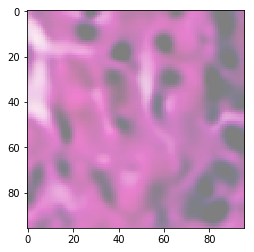

In [13]:
# Reconstructed image
plt.imshow(val_pred_img(3))

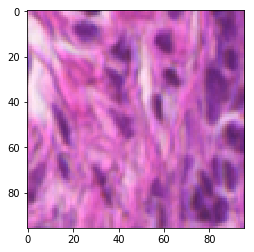

In [14]:
# Original image
plt.imshow(val_out_img(3))

In [ ]:
print('ANOMALY: {}'.format(anomaly.mean()))
print('NORMAL: {}'.format(normal.mean()))

# OC-NN

In [12]:
from tensorflow.keras import backend as K

In [13]:
# nu-quantile variable - we need to change it during run
r = K.variable(0.5, dtype=float, name='quantile')

The encoder weights are frozen. According to Algorithm 1 only weights of the FCN are updated.

In [ ]:
model.encoder.trainable = False

We use the latent vector of the autoencoder as an input to the OC-NN. OC-NN consists of FCN hidden layers and a single-node output layer.

In [14]:
# Encoder - Hidden - Output(1)
out = tf.keras.layers.Flatten()(model.encoder.output)
out = tf.keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
train_model = tf.keras.Model(model.encoder.input, out)

In [ ]:
# Encoder - Hidden - Output(1) - DecisionScore
out = tf.keras.layers.Lambda(lambda x: x - r)(out)
out_model = tf.keras.Model(model.encoder.input, out)

In [16]:
# Custom loss function to minimize
def ocnn_loss(_, y_pred):
    return (1 / 0.015) * K.mean(K.maximum(0.0, r - y_pred)) - r

train_model.compile(loss=ocnn_loss, optimizer=tf.keras.optimizers.Adam(0.00005))

In [25]:
# Get training datagen
train_ds, train_steps = datagen.get_training_dataset(total_samples=64*1500*1, augment_type=None)

In [26]:
# Train model
train_model.fit_generator(train_ds, steps_per_epoch=train_steps, epochs=1)

1500/1500 [==============================] - 152s 102ms/step - loss: -0.9998


Once the network has been trained for a single epoch/batch for a fixed value of $\nu$, we update the $\nu$ value: $\nu^{t+1} = \nu-\texttt{quantile of } \{\hat{y}_n^{t+1}\}^N_{n=1}$

In [ ]:
# Estimate nu-quantile
train_ds, train_steps = datagen.get_training_dataset(total_samples=64*1*1, augment_type=None)
y_pred = train_model.predict_generator(train_ds, steps=train_steps)
np.quantile(y_pred, 0.015)
K.set_value(r, np.quantile(y_pred, 0.015))
K.get_value(r)

30/10/2019
- It's possible that for training we need dataset/batches with r